# Sealed Auctions

We first implement the sealed auction game with a fixed number of bidders. Each bidder's reserve price is drawn from a uniform ditrisbution between 1 and some chosen parameter.

In [1]:
import zerosum as zs

In [80]:
from typing import ClassVar, cast
from dataclasses import dataclass
import random


@dataclass(slots=True, frozen=True)
class Reserve:
    reserve: int


@dataclass(slots=True, frozen=True)
class Bid:
    bid: int


Action = Reserve | Bid


@dataclass(slots=True, frozen=True)
class InfoSet:
    reserve: int
    bidders: int

    def actions(self) -> tuple[Action, ...]:
        return tuple(Bid(q) for q in range(0, 1 + self.reserve))


def sealed(bidders: int, reserve: int):

    @dataclass(slots=True, frozen=True)
    class SealedAuction:
        players: ClassVar[int] = bidders

        history: tuple[Action, ...] = ()

        @classmethod
        def default(cls):
            return cls()

        @property
        def terminal(self):
            return len(self.history) == 2 * bidders

        def payoff(self, player: zs.Player):
            reserves = [cast(Reserve, reserve).reserve for reserve in self.history[::2]]
            bids = [cast(Bid, bid).bid for bid in self.history[1::2]]
            argmax = max(range(bidders), key=bids.__getitem__)

            if argmax == player:
                return reserves[argmax] - bids[argmax]

            return 0
        
        @property
        def chance(self) -> bool:
            return len(self.history) % 2 == 0
        
        def chances(self):
            raise NotImplementedError
        
        def sample(self):
            return Reserve(random.randint(1, reserve))
        
        @property
        def active(self):
            return zs.Player(len(self.history) // 2)

        def infoset(self, player: zs.Player):
            reserve = cast(Reserve, self.history[-1])
            return InfoSet(reserve.reserve, self.players)
        
        def apply(self, action: Action):
            return self.__class__(self.history + (action,))
    
    return SealedAuction

An interesting fact is that CFR does not converge to an optimal strategy for this game. There are no theoretical garantees because the game is multiplayer and not zero sum. However a variant called LCFR converges well.

In [96]:
game = sealed(1, 5)
algo = zs.Algorithm(zs.ESLCFR(10), game)

In [97]:
from tqdm import trange

for _ in trange(1000):
    algo.once()

100%|██████████| 1000/1000 [00:00<00:00, 18930.44it/s]


In [98]:
algo.impl.strategies

{InfoSet(reserve=4, bidders=1): {Bid(bid=0): 94.90415913200708,
  Bid(bid=1): 0.0,
  Bid(bid=2): 0.0,
  Bid(bid=3): 0.0,
  Bid(bid=4): 0.0},
 InfoSet(reserve=2, bidders=1): {Bid(bid=0): 104.32911392405063,
  Bid(bid=1): 0.01808318264014469,
  Bid(bid=2): 0.01808318264014469},
 InfoSet(reserve=3, bidders=1): {Bid(bid=0): 102.20298372513562,
  Bid(bid=1): 0.0004520795660036167,
  Bid(bid=2): 0.0004520795660036167,
  Bid(bid=3): 0.0004520795660036167},
 InfoSet(reserve=1, bidders=1): {Bid(bid=0): 100.65551537070523,
  Bid(bid=1): 0.006329113924050631},
 InfoSet(reserve=5, bidders=1): {Bid(bid=0): 95.34840265220001,
  Bid(bid=1): 0.0018083182640144667,
  Bid(bid=2): 0.0006027727546714894,
  Bid(bid=3): 0.0,
  Bid(bid=4): 0.0,
  Bid(bid=5): 0.0}}

In [127]:
@dataclass(slots=True, frozen=True)
class Bidders:
    bidders: int


@dataclass(slots=True, frozen=True)
class RdBidders:
    players: ClassVar[int] = 10  # upper bound

    @classmethod
    def default(cls):
        return cls()

    @property
    def terminal(self):
        return False
    
    def payoff(self, player: zs.Player):
        raise NotImplementedError
    
    @property
    def chance(self):
        return True
    
    def chances(self):
        raise NotImplementedError
    
    def sample(self):
        return Bidders(random.randint(1, self.players))
    
    @property
    def active(self):
        raise NotImplementedError
    
    def infoset(self, player: zs.Player):
        raise NotImplementedError
    
    def apply(self, action: Bidders):
        return sealed(action.bidders, 30).default()

In [189]:
algo = zs.Algorithm(zs.ESLCFR(1000), RdBidders)

In [193]:
try:
    for _ in trange(50000):
        algo.once()
except KeyboardInterrupt:
    pass

100%|██████████| 50000/50000 [03:01<00:00, 275.01it/s]


In [194]:
import numpy as np


strategies = zs.normalize(algo.impl.strategies)
reserve = 25

strat = np.empty((RdBidders.players, reserve))
for bidders in range(1, RdBidders.players + 1):
    for bid, p in strategies[InfoSet(reserve - 1, bidders)].items():
        strat[bidders - 1, bid.bid] = p

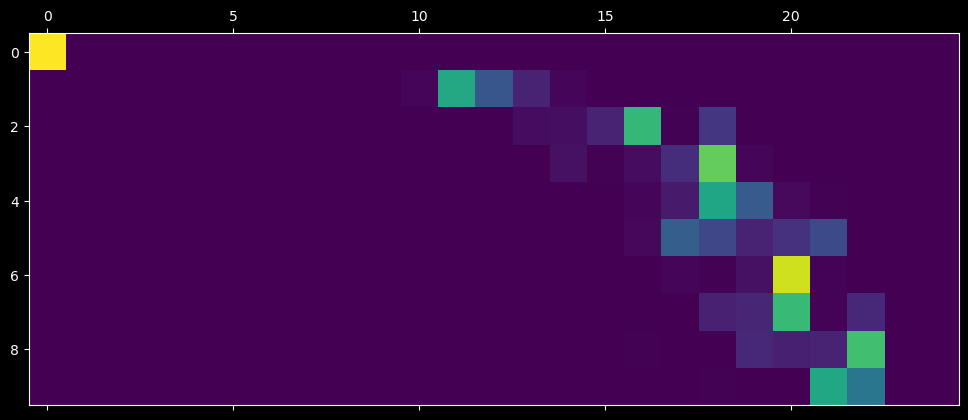

In [195]:
import matplotlib.pyplot as plt

plt.matshow(strat)